In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import datetime
import os
import gc

In [20]:
df_train = pd.read_csv('data/train.csv')

In [21]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [22]:
targets= df_train.target

In [23]:
filenames = ['data/jpeg/train/' + fname + '.jpg' for fname in df_train.image_name]

In [24]:
X = filenames
y = pd.get_dummies(targets)

In [25]:
# Set number of images to use for experimenting
First_Image = 0
Last_Image = 30000

In [26]:
x_train, x_val, y_train, y_val = train_test_split(X[:], y[:], test_size = 0.2, random_state = 42)

In [27]:
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [28]:
def create_df(image, target):
    image = process_image(image)
    return image, target

In [29]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train), tf.constant(y_train)))
train_data = train_data.map(create_df).batch(BATCH_SIZE).shuffle(buffer_size=len(x_train))

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_val), tf.constant(y_val)))
val_data = val_data.map(create_df).batch(BATCH_SIZE)

In [30]:
train_data

<ShuffleDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.uint8)>

In [31]:
INPUT_SIZE = [None, IMG_SIZE,IMG_SIZE, 3]
HIDDEN_SIZE1 = 256
HIDDEN_SIZE2 = 128
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2

In [32]:
Total_num_img = len(df_train)
Num_mlg = np.count_nonzero(df_train.target)
Num_bng = Total_num_img - Num_mlg

In [33]:
Weight_bng = 1/Num_bng * Total_num_img/2
Weight_mlg = 1/Num_mlg * Total_num_img/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

In [34]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [35]:
def create_model(retrain = False):
    model = []
    if retrain:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key=os.path.getctime)
        model = load_model(model_path)
        model.summary()
    else:
        model = Sequential([
                    Conv2D(64, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),

                    Conv2D(128, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),
                    
                    Conv2D(256, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),
                    
                    Flatten(),
                    Dense(HIDDEN_SIZE,activation='relu'),
                    Dense(OUTPUT_SIZE, activation='softmax')])

        model.build(INPUT_SIZE)

        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-6),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = ['accuracy'])

        model.summary()
    return model

In [36]:
model = create_model(False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  819456    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                 

In [69]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)

In [70]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
gc.collect()

6489

In [71]:
history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=EarlyStopping, class_weight = class_weights)

Epoch 1/100


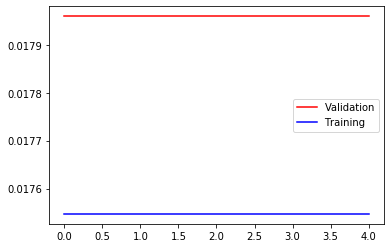

In [47]:
plt.plot(history.history['val_accuracy'], color = 'red')
plt.plot(history.history['accuracy'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.show()

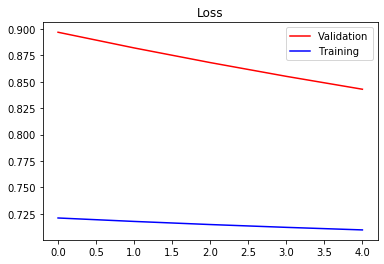

In [48]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

In [49]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [50]:
sfx = "Images {}_{}_DNN".format(First_Image, Last_Image)
save_model(model, suffix=sfx)

Saving model to: models\20200702060005-Images 0_30000_DNN.h5...


'models\\20200702060005-Images 0_30000_DNN.h5'